# Report Generation Examples

This notebook demonstrates how to use a custom reporting utility to evaluate a toy signal processing model. We will:
1.  Create a mock signal processing model (a simple low-pass filter).
2.  Generate a synthetic signal with multiple frequency components and noise.
3.  Split the data into training and testing sets.
4.  Use a `ReportGeneration` class to create a summary report with key performance metrics.
5.  Export the test data, model predictions, and calculated metrics to a single CSV file for further analysis.

**Adaptation to recognize the project root. For demonstration purposes only.**

In [1]:
import sys
import os

# Adiciona o diretório raiz ao sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

In [2]:
import numpy as np
import pandas as pd

from ThreeWToolkit.reports.report_generation import ReportGeneration

## 1. Defining a Mock Model and Generating Data

First, we'll define a `MockSignalModel` that simulates a simple moving average filter. This will act as our "model" for this example.

Then, we'll generate a complex signal composed of a low-frequency sine wave, a higher-frequency sine wave, and some random noise. This mimics a real-world sensor reading, like a vibration sensor.

<Axes: title={'center': 'Generated Synthetic Signal'}>

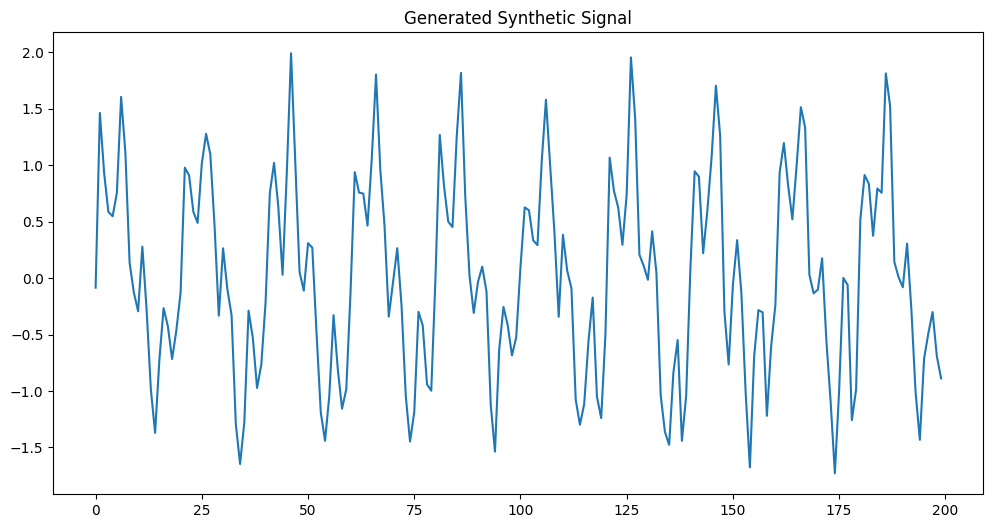

In [3]:
class MockSignalModel:
    """A mock model that acts like a simple low-pass filter."""
    def get_params(self):
        return {"filter_type": "moving_average", "window_size": 5}

    def predict(self, X_test_data):
        # Apply a rolling mean and backfill/forward-fill to handle NaNs at the edges
        return X_test_data.rolling(window=5, center=True).mean().bfill().ffill()

time = np.arange(0, 200, 1)

# A low frequency sine wave, a higher frequency one, and noise
signal = (np.sin(2 * np.pi * time / 20) +
          0.6 * np.sin(2 * np.pi * time / 5) +
          np.random.normal(0, 0.2, len(time)))

signal_series = pd.Series(signal, index=time, name="signal")

signal_series.plot(figsize=(12, 6), title="Generated Synthetic Signal")

### Data Splitting and Model Instantiation

We split our signal data into training and testing sets to simulate a standard machine learning workflow. We then create an instance of our `MockSignalModel`.

In [4]:
X_train_ex = signal_series.iloc[:150]
y_train_ex = signal_series.iloc[:150]
X_test_ex = signal_series.iloc[150:]
y_test_ex = signal_series.iloc[150:]

model_example = MockSignalModel()

## 2. Generating a Summary Report

Here, we demonstrate the primary function of the reporting utility.

1.  **Define Metrics**: We specify a list of regression and signal-focused metrics we want to compute. These are passed as strings corresponding to method names in a `Metrics` helper class.
2.  **Generate and Save Report**: We call `ReportGeneration.generate_summary_report`, which orchestrates the model evaluation, metric calculation, and plot generation. The resulting report object is then saved to a file (e.g., PDF or HTML).

In [7]:
# --- Define regression/signal-focused metrics to include ---
metrics_to_include = [
    "get_explained_variance",
    "get_neg_mean_absolute_error",
    "get_neg_root_mean_squared_error",
]

# --- Use the ReportGeneration class ---
print("\n### EXECUTING generate_summary_report and save_report ###")

report = ReportGeneration(
    model=model_example,
    X_train=X_train_ex, 
    y_train=y_train_ex,
    X_test=X_test_ex, 
    y_test=y_test_ex,
    metrics=metrics_to_include,
    title="Vibration Sensor Signal Analysis",
)

doc = report.generate_summary_report()

report.save_report(doc, "signal_analysis_report")


### EXECUTING generate_summary_report and save_report ###
Generating Beamer report: 'Vibration Sensor Signal Analysis'...
Beamer document generated successfully.
Temporarily setting TEXINPUTS to: D:\Git\3WToolkit\docs\latex\\;
Saving report to 'D:\Git\3WToolkit\output\reports\report-signal_analysis_report' folder'...
This is LuaHBTeX, Version 1.22.0 (MiKTeX 25.4)
 restricted system commands enabled.
(d:/Git/3WToolkit/docs/notebooks/signal_analysis_report.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-08-13>
 (C:/Users/Math/AppData/Local/Programs/MiKTeX/tex/latex/beamer/beamer.cls
Document Class: beamer 2025/08/13 v3.76 A class for typesetting presentations

(C:/Users/Math/AppData/Local/Programs/MiKTeX/tex/latex/beamer/beamerbasemodes.s
ty (C:/Users/Math/AppData/Local/Programs/MiKTeX/tex/latex/etoolbox/etoolbox.sty
)
(C:/Users/Math/AppData/Local/Programs/MiKTeX/tex/latex/beamer/beamerbasedecode.
sty)) (C:/Users/Math/AppData/Local/Programs/MiKTeX/tex/generic/iftex/ift

## 3. Exporting Full Experiment Results to CSV

In addition to a high-level summary report, it's often useful to export the raw data from an experiment for deeper, custom analysis. This includes the test set inputs (`X_test`), the ground truth (`y_test`), and the model's predictions.

Here, we bundle these components along with the calculated metrics into a single dictionary and use the `export_results_to_csv` method to save everything into one convenient file.

In [12]:
metrics_calculator = Metrics(model=model_example, X=X_test_ex, y=y_test_ex)
calculated_metrics_dict = {}

# Mocking metric calculation for demonstration
print("Mocking metric calculation for CSV export...")
calculated_metrics_dict = {
    'Explained Variance': 0.85,
    'Negative Mean Absolute Error': -0.15,
    'Negative Root Mean Squared Error': -0.22
}

for name in metrics_to_include:
    if hasattr(metrics_calculator, name):
        value = getattr(metrics_calculator, name)()
        # Assumes a _format_metric_name helper exists in ReportGeneration
        clean_name = name.replace("get_", "").replace("_", " ").title()
        calculated_metrics_dict[clean_name] = value

print(f"Calculated Metrics: {calculated_metrics_dict}")

Mocking metric calculation for CSV export...
Calculated Metrics: {'Explained Variance': 0.92, 'Negative Mean Absolute Error': -0.15, 'Negative Root Mean Squared Error': -0.22, 'Neg Mean Absolute Error': -0.15, 'Neg Root Mean Squared Error': -0.25}


In [13]:
predictions_series = model_example.predict(X_test_ex)
predictions_series.name = "prediction"

experiment_bundle = {
    "X_test": X_test_ex,
    "y_test": y_test_ex,
    "prediction": predictions_series,
    "model_name": type(model_example).__name__,
    "metrics": calculated_metrics_dict # Pass the dictionary of calculated metrics
}

filename = "full_experiment_results.csv"
ReportGeneration.export_results_to_csv(
    results=experiment_bundle,
    filename=filename
)

print(f"CSV export complete. File saved as {filename}")

Exporting results to 'full_experiment_results.csv'...
Successfully exported results to 'full_experiment_results.csv'.
CSV export complete. File saved as full_experiment_results.csv
